In [ ]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

In [ ]:
!ls

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
!mkdir MNIST_Fashion
!cp *.gz MNIST_Fashion/
from tensorflow.examples.tutorials.mnist import input_data
fmnist = input_data.read_data_sets("MNIST_Fashion/")

In [ ]:
#Training PArams
learning_rate = 0.0002
batch_size = 128
epochs = 100000

#Network params
image_dim = 784 #img sz is 28x28
gen_hidd_dim = 256
disc_hidd_dim  = 256
z_noise_dim = 100

def xavier_init(shape):
  return tf.random_normal(shape = shape, stddev= 1./tf.sqrt(shape[0]/2.0))

In [ ]:
weights = {
    "disc_H" : tf.Variable(xavier_init([image_dim, disc_hidd_dim])),
    "disc_final": tf.Variable(xavier_init([disc_hidd_dim,1])),
    "gen_H": tf.Variable(xavier_init([z_noise_dim, gen_hidd_dim])),
    "gen_final": tf.Variable(xavier_init([gen_hidd_dim, image_dim]))
}

bias = {
    "disc_H" : tf.Variable(xavier_init([disc_hidd_dim])),
    "disc_final": tf.Variable(xavier_init([1])),
    "gen_H": tf.Variable(xavier_init([gen_hidd_dim])),
    "gen_final": tf.Variable(xavier_init([image_dim]))
}

In [ ]:
def Discriminator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["disc_H"]), bias["disc_H"]))
  final_layer = (tf.add(tf.matmul(hidden_layer, weights["disc_final"]), bias["disc_final"]))
  disc_output = tf.nn.sigmoid(final_layer)
  return final_layer, disc_output


In [ ]:
#Generator NW
def Generator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["gen_H"]), bias["gen_H"]))
  final_layer = (tf.add(tf.matmul(hidden_layer, weights["gen_final"]), bias["gen_final"]))
  gen_output = tf.nn.sigmoid(final_layer)
  return gen_output


In [ ]:
#define placeholders for external input

z_input = tf.placeholder(tf.float32, shape = [None, z_noise_dim], name = "input_noise")
x_input = tf.placeholder(tf.float32, shape = [None, image_dim], name = "real_noise")


In [ ]:
# building the GEN NW
with tf.name_scope("Generator") as scope:
  output_Gen = Generator(z_input) #G(z)

 # Building the Disc NW
with tf.name_scope("Generator") as scope:
  real_output1_Disc, real_output_disc = Discriminator(x_input) #implements D(x)
  fake_output1_Disc, fake_output_disc = Discriminator(output_Gen) # implements D(G(x))



In [ ]:
#first kind of loss
with tf.name_scope("Discriminator_Loss") as scope:
  Discriminator_Loss = -tf.reduce_mean(tf.log(real_output_disc+ 0.0001)+tf.log(1.- fake_output_disc+0.0001))

with tf.name_scope("Genetator_Loss") as scope:
  Generator_Loss = -tf.reduce_mean(tf.log(fake_output_disc+ 0.0001)) # due to max log(D(G(x)))

  # T-board summary

  Disc_loss_total = tf.summary.scalar("Disc_Total_loss", Discriminator_Loss)
  Gen_loss_total = tf.summary.scalar("Gen_loss", Generator_Loss)


In [ ]:
#second kind of loss
with tf.name_scope("Discriminator_Loss") as scope:
  Disc_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = real_output1_Disc, labels = tf.ones_like(real_output1_Disc)))
  Disc_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_output1_Disc, labels = tf.zeros_like(fake_output1_Disc)))
  Discriminator_Loss = Disc_real_loss + Disc_fake_loss


with tf.name_scope("Genetator_Loss") as scope:
  Generator_Loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_output1_Disc, labels = tf.ones_like(fake_output1_Disc)))

  # Tensorboarf summary

Disc_loss_real_summary = tf.summary.scalar('Disc_loss_real', Disc_real_loss)
Disc_loss_fake_summary = tf.summary.scalar('Disc_loss_fake', Disc_fake_loss)
Disc_loss_summary = tf.summary.scalar('Disc_total_loss', Discriminator_Loss)

Disc_loss_total = tf.summary.merge([Disc_loss_real_summary, Disc_loss_fake_summary, Disc_loss_summary])
Gen_loss_total = tf.summary.scalar('Gen_loss', Generator_Loss)




In [ ]:
# Define the variables

Generator_var = [weights["gen_H"], weights["gen_final"], bias["gen_H"], bias["gen_final"]]
Discriminator_var = [weights["disc_H"], weights["disc_final"], bias["disc_H"], bias["disc_final"]]

#Define the optimizer
with tf.name_scope("Optimizer_Discriminator") as scope:
  Discriminator_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Discriminator_Loss, var_list = Discriminator_var)

with tf.name_scope("Optimizer_Generator") as scope:
  Generator_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Generator_Loss, var_list = Generator_var)


In [ ]:
# Initialize the variables

init = tf.global_variables_initializer()
sess = tf.Session()

sess.run(init)
writer = tf.summary.FileWriter("./log", sess.graph)

for epoch in range(epochs):
  x_batch, _ = fmnist.train.next_batch(batch_size)

  #Generate noise to feed Discriminator
  z_noise = np.random.uniform(-1.,1.,size = [batch_size, z_noise_dim])
  _, Disc_loss_epoch = sess.run([Discriminator_optimize, Discriminator_Loss], feed_dict = {x_input:x_batch, z_input:z_noise})
  _, Gen_loss_epoch = sess.run([Generator_optimize, Generator_Loss], feed_dict = {z_input:z_noise})

  #Running the Discriminator summary
  summary_Disc_loss = sess.run(Disc_loss_total, feed_dict = {x_input:x_batch, z_input:z_noise})
  # Adding the Discriminator summary
  writer.add_summary(summary_Disc_loss, epoch)

  #Running the Generator summary
  summary_Gen_loss = sess.run(Gen_loss_total, feed_dict = {z_input:z_noise})
  # Adding the Generator summary
  writer.add_summary(summary_Gen_loss, epoch)

  if epoch % 2000 == 0:
    print("Steps: {0}: Generator Loss: {1}, Discriminator Loss:{2}".format(epoch, Gen_loss_epoch, Disc_loss_epoch))




Steps: 0: Generator Loss: 0.2859601676464081, Discriminator Loss:2.233637571334839
Steps: 2000: Generator Loss: 3.0023133754730225, Discriminator Loss:0.2748841345310211
Steps: 4000: Generator Loss: 2.8812737464904785, Discriminator Loss:0.28830602765083313
Steps: 6000: Generator Loss: 3.231123924255371, Discriminator Loss:0.2344113290309906
Steps: 8000: Generator Loss: 2.633310079574585, Discriminator Loss:0.31073784828186035
Steps: 10000: Generator Loss: 2.414632797241211, Discriminator Loss:0.4111747741699219
Steps: 12000: Generator Loss: 2.3037047386169434, Discriminator Loss:0.4018137753009796
Steps: 14000: Generator Loss: 2.192345142364502, Discriminator Loss:0.41327720880508423
Steps: 16000: Generator Loss: 3.166553497314453, Discriminator Loss:0.35595840215682983
Steps: 18000: Generator Loss: 2.51501727104187, Discriminator Loss:0.5612295866012573
Steps: 20000: Generator Loss: 2.9820990562438965, Discriminator Loss:0.49208712577819824
Steps: 22000: Generator Loss: 2.68129611015

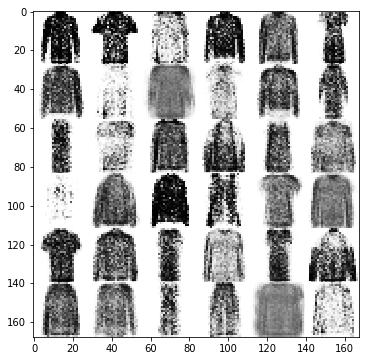

In [ ]:
#Testing
# Generate images from noise, using the generator network

n = 6
canvas = np.empty((28*n, 28*n))
for i in range(n):
  #Noise input
  z_noise = np.random.uniform(-1.,1., size = [batch_size, z_noise_dim])
  # Generate image from noise
  g = sess.run(output_Gen, feed_dict = {z_input:z_noise})
  # Reverse colors for better display
  g=-1*(g-1)
  for j in range(n):
    #Draw the generated digits
    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = g[j].reshape([28, 28])

plt.figure(figsize = (n,n))
plt.imshow(canvas, origin = "upper", cmap = "gray")
plt.show()